In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [2]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [3]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [4]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)
    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)
    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))
    
    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

In [5]:
import os
import numpy as np
from tqdm import tqdm
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 100  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"
d_loss_accumulated = []
g_loss_accumulated = []
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_running = []
    g_loss_running = []
#     for step, real_images in tqdm(enumerate(dataset)):
    for real_images in tqdm(dataset):

        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

#         # Logging.
#         if step % 200 == 0:
            # Print metrics
#         print("discriminator loss at step %d: %.2f" % (step, d_loss))
#         print("adversarial loss at step %d: %.2f" % (step, g_loss))

        # Save one generated image
#         img = keras.utils.array_to_img(generated_images[0] * 255.0, scale=False)
#         img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
        d_loss_running.append(d_loss)
        g_loss_running.append(g_loss)
        # To limit execution time we stop after 10 steps.
        # Remove the lines below to actually train the model!
#         if step > 10:
#             break
    d_loss_accumulated.append(np.average(d_loss_running))
    g_loss_accumulated.append(np.average(g_loss_running))
    print(f"Epoch: {epoch+1}, Discriminator loss: {d_loss_accumulated[-1]}, Generator loss: {g_loss_accumulated[-1]}")


11490434/11490434 [==============================] - 0s 0us/step

Start epoch 0


100%|██████████| 1094/1094 [00:25<00:00, 42.22it/s]


Epoch: 1, Discriminator loss: 0.45399630069732666, Generator loss: 1.3699672222137451

Start epoch 1


100%|██████████| 1094/1094 [00:15<00:00, 71.20it/s]


Epoch: 2, Discriminator loss: 0.4035787284374237, Generator loss: 1.7577627897262573

Start epoch 2


100%|██████████| 1094/1094 [00:15<00:00, 71.06it/s]


Epoch: 3, Discriminator loss: 0.6477903723716736, Generator loss: 0.9501860737800598

Start epoch 3


100%|██████████| 1094/1094 [00:15<00:00, 71.28it/s]


Epoch: 4, Discriminator loss: 0.6563695073127747, Generator loss: 0.8908228278160095

Start epoch 4


100%|██████████| 1094/1094 [00:15<00:00, 71.15it/s]


Epoch: 5, Discriminator loss: 0.6417465209960938, Generator loss: 0.8959712982177734

Start epoch 5


100%|██████████| 1094/1094 [00:15<00:00, 71.27it/s]


Epoch: 6, Discriminator loss: 0.6257830858230591, Generator loss: 0.92130446434021

Start epoch 6


100%|██████████| 1094/1094 [00:15<00:00, 71.08it/s]


Epoch: 7, Discriminator loss: 0.6169218420982361, Generator loss: 0.9427573084831238

Start epoch 7


100%|██████████| 1094/1094 [00:15<00:00, 71.29it/s]


Epoch: 8, Discriminator loss: 0.6038253903388977, Generator loss: 0.9633976817131042

Start epoch 8


100%|██████████| 1094/1094 [00:15<00:00, 71.05it/s]


Epoch: 9, Discriminator loss: 0.5861639976501465, Generator loss: 1.0022735595703125

Start epoch 9


100%|██████████| 1094/1094 [00:15<00:00, 71.14it/s]


Epoch: 16, Discriminator loss: 0.5899893641471863, Generator loss: 1.0245851278305054

Start epoch 16


100%|██████████| 1094/1094 [00:15<00:00, 71.32it/s]


Epoch: 17, Discriminator loss: 0.5922704339027405, Generator loss: 1.0231966972351074

Start epoch 17


100%|██████████| 1094/1094 [00:15<00:00, 71.22it/s]


Epoch: 18, Discriminator loss: 0.5950937271118164, Generator loss: 1.022925615310669

Start epoch 18


100%|██████████| 1094/1094 [00:15<00:00, 71.32it/s]


Epoch: 19, Discriminator loss: 0.5953434109687805, Generator loss: 1.019898772239685

Start epoch 19


100%|██████████| 1094/1094 [00:15<00:00, 71.12it/s]


Epoch: 20, Discriminator loss: 0.5946460962295532, Generator loss: 1.0173710584640503

Start epoch 20


100%|██████████| 1094/1094 [00:15<00:00, 71.31it/s]


Epoch: 21, Discriminator loss: 0.5946699380874634, Generator loss: 1.021133303642273

Start epoch 21


100%|██████████| 1094/1094 [00:15<00:00, 71.10it/s]


Epoch: 22, Discriminator loss: 0.5942920446395874, Generator loss: 1.015259861946106

Start epoch 22


100%|██████████| 1094/1094 [00:15<00:00, 71.28it/s]


Epoch: 23, Discriminator loss: 0.5949201583862305, Generator loss: 1.021320104598999

Start epoch 23


100%|██████████| 1094/1094 [00:15<00:00, 70.94it/s]


Epoch: 24, Discriminator loss: 0.5981084704399109, Generator loss: 1.0197274684906006

Start epoch 24


100%|██████████| 1094/1094 [00:15<00:00, 71.26it/s]


Epoch: 25, Discriminator loss: 0.5978100895881653, Generator loss: 1.0194226503372192

Start epoch 25


100%|██████████| 1094/1094 [00:15<00:00, 71.16it/s]


Epoch: 26, Discriminator loss: 0.5991197824478149, Generator loss: 1.0179998874664307

Start epoch 26


100%|██████████| 1094/1094 [00:15<00:00, 71.29it/s]


Epoch: 27, Discriminator loss: 0.6011921763420105, Generator loss: 1.015239953994751

Start epoch 27


100%|██████████| 1094/1094 [00:15<00:00, 71.29it/s]


Epoch: 28, Discriminator loss: 0.602726936340332, Generator loss: 1.011317253112793

Start epoch 28


100%|██████████| 1094/1094 [00:15<00:00, 71.27it/s]


Epoch: 29, Discriminator loss: 0.5999833941459656, Generator loss: 1.014997959136963

Start epoch 29


100%|██████████| 1094/1094 [00:15<00:00, 71.22it/s]


Epoch: 30, Discriminator loss: 0.6024037599563599, Generator loss: 1.0111770629882812

Start epoch 30


100%|██████████| 1094/1094 [00:15<00:00, 71.27it/s]


Epoch: 31, Discriminator loss: 0.6034326553344727, Generator loss: 1.0103096961975098

Start epoch 31


100%|██████████| 1094/1094 [00:15<00:00, 71.26it/s]


Epoch: 32, Discriminator loss: 0.6025751233100891, Generator loss: 1.0158177614212036

Start epoch 32


100%|██████████| 1094/1094 [00:15<00:00, 71.22it/s]


Epoch: 33, Discriminator loss: 0.6027467250823975, Generator loss: 1.0091787576675415

Start epoch 33


100%|██████████| 1094/1094 [00:15<00:00, 71.00it/s]


Epoch: 34, Discriminator loss: 0.6043993234634399, Generator loss: 1.0148446559906006

Start epoch 34


100%|██████████| 1094/1094 [00:15<00:00, 71.31it/s]


Epoch: 35, Discriminator loss: 0.6050862073898315, Generator loss: 1.0087051391601562

Start epoch 35


100%|██████████| 1094/1094 [00:15<00:00, 71.11it/s]


Epoch: 36, Discriminator loss: 0.6062127947807312, Generator loss: 1.0108656883239746

Start epoch 36


 78%|███████▊  | 848/1094 [00:11<00:03, 70.24it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1094/1094 [00:15<00:00, 71.04it/s]


Epoch: 73, Discriminator loss: 0.6142971515655518, Generator loss: 0.9945092797279358

Start epoch 73


100%|██████████| 1094/1094 [00:15<00:00, 71.38it/s]


Epoch: 74, Discriminator loss: 0.6115605235099792, Generator loss: 0.9924769401550293

Start epoch 74


100%|██████████| 1094/1094 [00:15<00:00, 71.27it/s]


Epoch: 75, Discriminator loss: 0.6137124300003052, Generator loss: 0.9932548999786377

Start epoch 75


100%|██████████| 1094/1094 [00:15<00:00, 71.28it/s]


Epoch: 76, Discriminator loss: 0.6133688688278198, Generator loss: 0.9953532814979553

Start epoch 76


100%|██████████| 1094/1094 [00:15<00:00, 71.16it/s]


Epoch: 77, Discriminator loss: 0.6125878095626831, Generator loss: 0.9916607141494751

Start epoch 77


100%|██████████| 1094/1094 [00:15<00:00, 71.27it/s]


Epoch: 78, Discriminator loss: 0.6121058464050293, Generator loss: 0.995171844959259

Start epoch 78


100%|██████████| 1094/1094 [00:15<00:00, 71.23it/s]


Epoch: 79, Discriminator loss: 0.6118926405906677, Generator loss: 0.9969930052757263

Start epoch 79


100%|██████████| 1094/1094 [00:15<00:00, 71.36it/s]


Epoch: 80, Discriminator loss: 0.6121240854263306, Generator loss: 0.9958779215812683

Start epoch 80


100%|██████████| 1094/1094 [00:15<00:00, 71.15it/s]


Epoch: 81, Discriminator loss: 0.6120799779891968, Generator loss: 0.9969234466552734

Start epoch 81


100%|██████████| 1094/1094 [00:15<00:00, 71.36it/s]


Epoch: 82, Discriminator loss: 0.6133981943130493, Generator loss: 1.0013853311538696

Start epoch 82


100%|██████████| 1094/1094 [00:15<00:00, 71.23it/s]


Epoch: 83, Discriminator loss: 0.6105707883834839, Generator loss: 1.0052584409713745

Start epoch 83


100%|██████████| 1094/1094 [00:15<00:00, 71.36it/s]


Epoch: 84, Discriminator loss: 0.60950767993927, Generator loss: 1.003007173538208

Start epoch 84


100%|██████████| 1094/1094 [00:15<00:00, 71.29it/s]


Epoch: 85, Discriminator loss: 0.6114980578422546, Generator loss: 1.005287766456604

Start epoch 85


100%|██████████| 1094/1094 [00:15<00:00, 71.27it/s]


Epoch: 86, Discriminator loss: 0.6117770671844482, Generator loss: 1.0030088424682617

Start epoch 86


100%|██████████| 1094/1094 [00:15<00:00, 71.26it/s]


Epoch: 87, Discriminator loss: 0.6102085113525391, Generator loss: 1.0071803331375122

Start epoch 87


100%|██████████| 1094/1094 [00:15<00:00, 71.32it/s]


Epoch: 88, Discriminator loss: 0.6118237972259521, Generator loss: 1.0055909156799316

Start epoch 88


100%|██████████| 1094/1094 [00:15<00:00, 71.07it/s]


Epoch: 89, Discriminator loss: 0.6120173335075378, Generator loss: 1.0017327070236206

Start epoch 89


100%|██████████| 1094/1094 [00:15<00:00, 71.37it/s]


Epoch: 90, Discriminator loss: 0.6114221811294556, Generator loss: 0.9991429448127747

Start epoch 90


100%|██████████| 1094/1094 [00:15<00:00, 71.20it/s]


Epoch: 91, Discriminator loss: 0.6086950302124023, Generator loss: 1.0053211450576782

Start epoch 91


100%|██████████| 1094/1094 [00:15<00:00, 71.39it/s]


Epoch: 92, Discriminator loss: 0.6114898920059204, Generator loss: 1.0041242837905884

Start epoch 92


100%|██████████| 1094/1094 [00:15<00:00, 71.18it/s]


Epoch: 93, Discriminator loss: 0.6106150150299072, Generator loss: 1.0027871131896973

Start epoch 93


 42%|████▏     | 456/1094 [00:06<00:08, 71.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



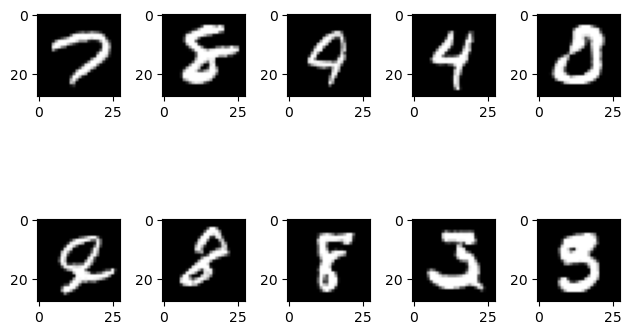

In [9]:
from matplotlib import pyplot as plt

batch_size = 10
random_latent_vectors = tf.random.normal(shape=(10, latent_dim))
generated_images = generator(random_latent_vectors)
for i in range(batch_size):
    plt.subplot(2,5,i+1)
    plt.imshow(generated_images[i,:,:,:], cmap="gray")
plt.tight_layout()
plt.show()

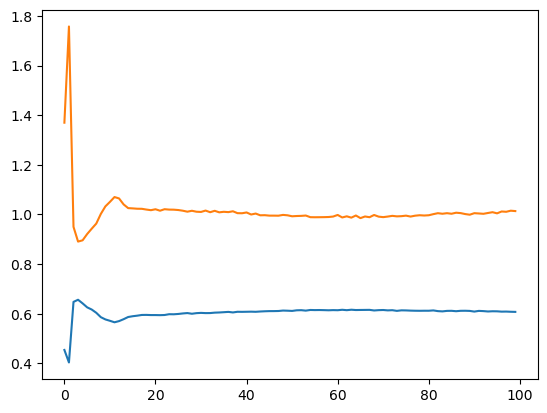

In [10]:
plt.plot(d_loss_accumulated)
plt.plot(g_loss_accumulated)